# Data Programming cw 2 

## contents
- Introduction
- Aims and objectives
- 3

## Introduction
This is a data analysis of the academic journal frontiers

## Aims and Objectives
1. There is a common hypothesis in the field of neurosceince that there is a growing body of experimental results and a lack of theoretical work. We wish to test this hypothesis on the relevant neuroscience journals published by frontiers.
2. It is common for the brain to be described as a complex system. The field of complexity science would seem to agree with this analysis. Complex systems do not have an agreed upon definition but there does seem to be a general concencus amoung scientisits concered with them that they tend to have charachteristic properties. One such property is emergent phenomena (The idea that the whole is more than the sum of its parts posing a difficulty to traditional reductionist methods of analysis). Therefore i would like to see how often this issue is cited in the literature and possibly analysi the sentiment towards it.
3. Possibly doing a deeper dive on articles that match our criteria of interest. Such as, a sentiment analysis on the top original research articles compared to the hypothesis and theory articles.

Imports we will need

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import pandas as pd
from datetime import datetime

#### Data acquisition
The exploratory analysis indicated more data on specific journals would likely yeild more insights and so we will begin by collecting article data from all(OR SOME???) of the neuroscience journals.

Maximising the browser window allows more content can be loaded at each scroll and therefore scraped faster as this process is quite time consuming. 

In [2]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
aging_neuroscience = "https://www.frontiersin.org/journals/aging-neuroscience/articles"
synaptic_neuroscience = "https://www.frontiersin.org/journals/synaptic-neuroscience/articles"
driver.get(aging_neuroscience)
driver.maximize_window()  # make window bigger so more content can be loaded at once for faster scraping.

Now check that the page has loaded and handle the cookies pop up.

In [3]:
wait = WebDriverWait(driver, 10)
cookies = wait.until(expected_conditions.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")))
cookies.click()

For some reason unknown to me the old method of scrolling doesnt seem to work on these pages. To overcome this we check the height of the page at each iteration of a loop and scroll by that amount. The added sleep command gives the page time to load and means the height changes on every iteration of the loop so it can be checked. It is not a very elegant or robust solution but it works. 

In [4]:
while True:
    previous_height = driver.execute_script("return document.documentElement.scrollHeight")
    driver.execute_script("window.scrollTo(0, " + str(previous_height) + ");")
    time.sleep(2)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if previous_height == new_height:
        break

soup = BeautifulSoup(driver.page_source, 'html.parser')

The articles and thier corresponding data are displayed on the webpage in this "card" format so each article card needs to be extracted.

In [5]:
def get_article_cards(soup):
    scraped_article_cards = soup.find_all('article', class_='CardArticle')
    article_cards = []
    for article_card in scraped_article_cards:
        article_cards.append(article_card)
    return article_cards

article_cards = get_article_cards(soup)

Now we extract the title and data for each article and organise this information in a dictionary so it can be easily converted to a pandas dataframe.

In [6]:
def get_article_metrics(article):
    article_metrics = article.find('ul', class_='CardArticle__metrics')
    split_metrics = article_metrics.text.split()
    is_float = re.compile("^[0-9]*.[0-9]*$")
    keys = []
    values = []
    for metric in split_metrics:
        metric = metric.replace(",", "")
        if metric.isdigit() or is_float.match(metric):
            values.append(float(metric))
        else:
            keys.append(metric)
    return dict(zip(keys, values))


def get_article_authors(article):
    article_authors = article.find('ul', class_='CardArticle__authors')
    authors = {}
    author_index = 1
    for author in article_authors:
        if author != "\n":
            authors.update({author_index: author.text.strip()}) # add each author as a numbered column. Number 1 is the primary author number 2 the secondary and so on...
            author_index = author_index + 1
    authors.update({"article authors": len(authors)})
    return authors


def get_title(article_title):
    title = article_title.text.replace("\n", "")
    title = re.sub(' +', ' ', title)
    return title.strip()


def get_article_status(article):
    article_date = article.find('p', class_='CardArticle__date')
    status = article_date.text.strip().split()
    return status[0]


def get_article_date(article):
    article_date = article.find('p', class_='CardArticle__date')
    date_info = article_date.text.strip().split()
    date_string = date_info[2] + date_info[3] + date_info[4]
    date = datetime.strptime(date_string, '%d%b%Y')
    return date


def get_article_data(article_cards):
    article_data = {}
    for article in article_cards:
        article_title = article.find('h1', class_='CardArticle__title')
        article_type = article.find('p', class_='CardArticle__type')
        article_journal = article.find('div', class_='CardArticle__journal__name')
        title = get_title(article_title)

        article_data[title] = {"article type": article_type.text,
                               "article date": get_article_date(article),
                               "article status": get_article_status(article),
                               "article journal": article_journal.text}
        article_data[title].update(get_article_authors(article))
        article_data[title].update(get_article_metrics(article))
    return article_data

data = get_article_data(get_article_cards(soup))

In [7]:
df = pd.DataFrame(data)
df_transpose = df.transpose()
df_describe = df_transpose.copy()

In [8]:
display(df_describe)

,article type,article date,article status,article journal,1,2,3,4,5,6,7,8,article authors,9,10,views
Amyloid beta (Aβ) accumulations and enhanced forebrain neuronal development and neuronal network formation in cerebral organoids of Dutch-type Cerebral Amyloid Angiopathy patients,Original Research,2022-12-29,Accepted,Frontiers in Aging Neuroscience,Elena Daoutsali,Barry A Pepers,Stavros Stamatakis,Linda M Van Der Graaf,Gisela Terwindt,David A Parfitt,Ronald A.M Buijsen,Willeke M.C Van Roon-Mom,8,NaN,NaN,NaN
Association of Inflammatory Bowel Disease and Related Medication Exposure with Risk of Alzheimer's Disease: An Updated Meta-Analysis,Systematic Review,2022-12-29,Accepted,Frontiers in Aging Neuroscience,Yinghao Xing,Pei Li,Yuanyuan Jia,Kexin Zhang,Ming Liu,Jingjing Jiang,NaN,NaN,6,NaN,NaN,NaN
Role of Microglia Autophagy in Age-Related Neurodegenerative Diseases,Review,2022-12-28,Accepted,Frontiers in Aging Neuroscience,Mingkai Lin,Hongwen Yu,Qiuyan Xie,Zhiyun Xu,Pei Shang,NaN,NaN,NaN,5,NaN,NaN,NaN
Impact of Glycosylated Hemoglobin on Early Neurological Deterioration and Functional Outcomes in Acute Mild Ischemic Stroke Patients Treated With Intravenous Thrombolysis,Original Research,2022-12-28,Accepted,Frontiers in Aging Neuroscience,Lin Han,Zhangyan Hou,Mingwei Ma,Dongxue Ding,Dapeng Wang,Qi Fang,NaN,NaN,6,NaN,NaN,NaN
Urinary dysfunction in patients with vascular cognitive impairment: a review,Review,2022-12-28,Accepted,Frontiers in Aging Neuroscience,Panpan Zhao,GuiMei Zhang,Yanxin Shen,Lin Shi,Zicheng Wang,Chunxiao Wei,Weijie Zhai,Li Sun,8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Editorial: Biomarkers to disentangle the physiological from pathological brain aging, volume II",Editorial,2022-11-22,Published,Frontiers in Aging Neuroscience,Franca Rosa Guerini,Beatrice Arosio,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,524.0
Association between white matter alterations and domain-specific cognitive impairment in cerebral small vessel disease: A meta-analysis of diffusion tensor imaging,Systematic Review,2022-11-22,Published,Frontiers in Aging Neuroscience,Yao Xie,Le Xie,Fuliang Kang,Junlin Jiang,Ting Yao,Guo Mao,Rui Fang,Jianhu Fan,9,Dahua Wu,NaN,585.0
The NLRP3 inflammasome is a potential mechanism and therapeutic target for perioperative neurocognitive disorders,Review,2022-11-21,Accepted,Frontiers in Aging Neuroscience,Jiayue Li,Li Li,Jiannan He,Jianhong Xu,Fangping Bao,NaN,NaN,NaN,5,NaN,NaN,NaN
Environmental enrichment improves declined cognition induced by prenatal inflammatory exposure in aged CD-1 mice: Role of NGPF2 and PSD-95,Original Research,2022-11-21,Published,Frontiers in Aging Neuroscience,Ming-Zhu Ni,Yue-Ming Zhang,Yun Li,Qi-Tao Wu,Zhe-Zhe Zhang,Jing Chen,Bao-Ling Luo,Xue-Wei Li,9,Gui-Hai Chen,NaN,713.0


#### Data screening and cleaning
Checking the data for null values shows we have a fairly comprehensive data set. Most of the null values are for the additional author columns with column 1 having no null values so every paper has at least one stated author. 

In [9]:
print(df_describe.isnull().sum())
print("total =", df_describe.isnull().sum().sum())

article type         0
article date         0
article status       0
article journal      0
1                    0
2                    1
3                    6
4                   16
5                   35
6                   55
7                   79
8                  106
article authors      0
9                  122
10                 131
views              106
dtype: int64
total = 657


We will assume that articles with null values for citations and views do not have any citations and views and so we can change this to 0.

In [10]:
# CHANGE NULL VALUES FOR CITATIONS AND VIEWS TO 0

<AxesSubplot:>

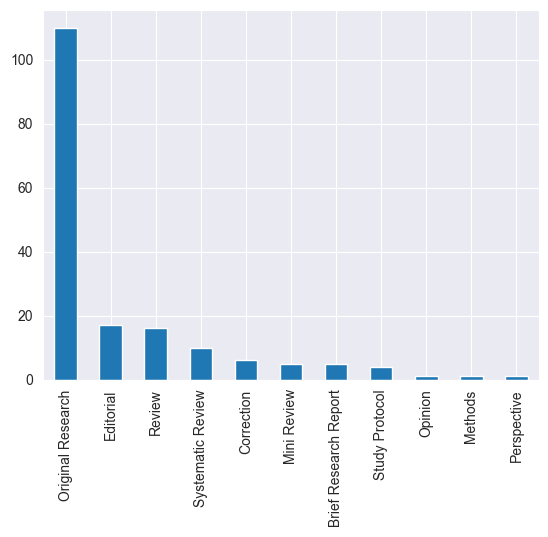

In [11]:
df_describe['article type'].value_counts().plot(kind='bar')

<AxesSubplot:>

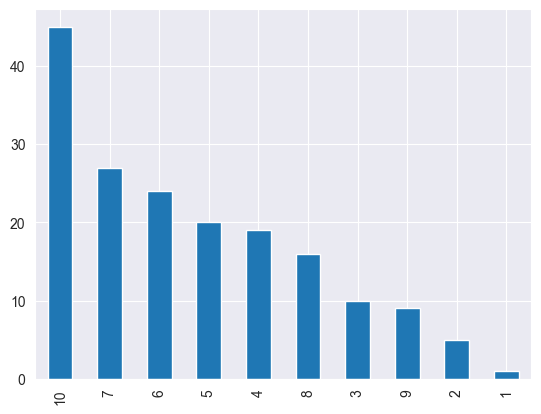

In [12]:
df_describe['article authors'].value_counts().plot(kind='bar')

In [13]:
df_describe[1].value_counts()

Lisa Perus             2
Yang Liu               2
Alica Rogojin          2
Marte Stine Einstad    1
Shishuai Wang          1
                      ..
Yen-Chang Huang        1
Peiyao Zhang           1
Yuchen Wang            1
Ningtian Ma            1
Fushun Wang            1
Name: 1, Length: 173, dtype: int64

In [14]:
df_describe['citations'].value_counts().plot(kind='bar', figsize=(20,7))

KeyError: 'citations'